## Cookbook recipe: Access and plot ipyrad stats in R

Jupyter notebooks provide a convenient interface for sharing data and functions between Python and R through use of the Python `rpy2` module. By combining all of your code from across multiple languages inside a single notebook your workflow from analyses to plots is easy to follow and reproduce. In this notebook, I show an example of exporting data from an ipyrad JSON object into R so that we can create high quality plots using plotting libraries in R.  



### Why do this?
A large motivation for creating the JSON storage object for ipyrad Assemblies is that this object stores all of the information for an entire assembly, and thus provides a useful portable format. This way you can execute very large assemblies on a remote HPC cluster and simply import the small JSON file onto your laptop to analyze and compare its size and other stats. It is of course easiest to analyze the stats in Python since ipyrad has a built-in parser for these JSON objects. However, many users may prefer to use R for plotting, and so here we show how to easily transfer results from ipyrad to R. 


### Two ways of accessing data in the ipyrad JSON file:
1. Load the data in with the ipyrad API and save to CSV. 
2. Load the data in with the ipyrad API and export to R using rpy2.

### Start by importing ipyrad

In [2]:
## import ipyrad and give it a shorter name
import ipyrad as ip

### Either create a new ipyrad assembly or load an existing one:
Here we use the API to run the example RAD data set, which only takes about 3 minutes on a 4-core laptop. 

In [3]:
## create a test assembly
data = ip.Assembly("data")
data.set_params('project_dir', 'test')
data.set_params('raw_fastq_path', 'ipsimdata/rad_example_R1_.fastq.gz')
data.set_params('barcodes_path', 'ipsimdata/rad_example_barcodes.txt')

## Assemble data set; runs steps 1-7
data.run('1')

  New Assembly: data

  Assembly: data
  [####################] 100%  chunking large files  | 0:00:00 | s1 | 
  [####################] 100%  sorting reads         | 0:00:02 | s1 | 
  [####################] 100%  writing/compressing   | 0:00:00 | s1 | 


### Or load a finished assembly from its JSON file

In [4]:
## load the JSON file for this assembly
data = ip.load_json("test/data.json")

  loading Assembly: data
  from saved path: ~/Documents/ipyrad/tests/test/data.json


### Look at the stats summary for this assembly

In [5]:
## Data can be accessed from the object's stats and stats_df attributes
print data.stats

      state  reads_raw
1A_0      1      19862
1B_0      1      20043
1C_0      1      20136
1D_0      1      19966
2E_0      1      20017
2F_0      1      19933
2G_0      1      20030
2H_0      1      20199
3I_0      1      19885
3J_0      1      19822
3K_0      1      19965
3L_0      1      20008


### Load R-language extension

In [6]:
## This requires that you have the Python module `rpy2` installed. 
## If you do not, it can be installed in anaconda with: 

## conda install rpy2

### Transfer Python object to R
There are a few odd tricks to using this module. One being that you shouldn't try to transfer objects with '.' in their names. R doesn't like that. So simply rename these objects before passing them. Below I rename the stats data frame and then use the '-i' flag in R to import it into R namespace. The "%R" at the beginning of the line tells IPyhton to execute just that line as R code. 

In [7]:
%load_ext rpy2.ipython

ImportError: No module named simplegeneric

In [25]:
## rename data.stats as statsDF
statsDF = data.stats

## import statsDF into R namespace
%R -i statsDF

### Now R knows about statsDF
We can access it just like a normal R DataFrame, and even create plots. Using the cell header %%R everything in the cell will execute as R code. 

In [26]:
%%R 
print(statsDF)


     state reads_raw reads_filtered clusters_total clusters_hidepth  hetero_est
1A_0     6     20093          20093           1000             1000 0.001965305
1B_0     6     19938          19938           1000             1000 0.001865104
1C_0     6     20054          20054           1000             1000 0.001968599
1D_0     6     20066          20066           1000             1000 0.001934149
2E_0     6     19838          19838           1000             1000 0.002077262
2F_0     6     20033          20033           1000             1000 0.001886744
2G_0     6     20145          20145           1000             1000 0.001898473
2H_0     6     20158          20158           1000             1000 0.001931724
3I_0     6     20010          20010           1000             1000 0.001865512
3J_0     6     19977          19977           1000             1000 0.002291394
3K_0     6     20061          20061           1000             1000 0.001808438
3L_0     6     19975          19975     

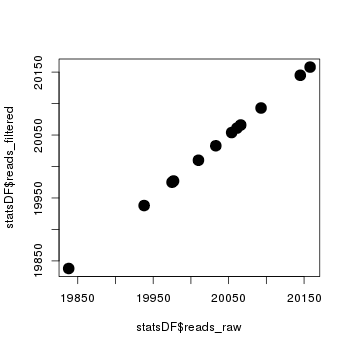

In [92]:
%%R -w 350 -h 350
## the dimensions above tell IPython how big to make the embedded figure
## alternatively you can adjust the size when you save the figure

plot(statsDF$reads_raw, 
     statsDF$reads_filtered, 
     pch=20, cex=3)

### Let's transfer more data from Python to R

In [13]:
### Other stats from our assembly are also available.
### First store names and then import into R
s5 = data.stats_dfs.s5
s7L = data.stats_dfs.s7_loci
s7S = data.stats_dfs.s7_snps
s7N = data.stats_dfs.s7_samples

## no spaces allowed between comma-separated names when 
## transferring multiple objects to R
%R -i s5,s7L,s7S,s7N

### Plot coverage among samples 
Kinda boring in this example...

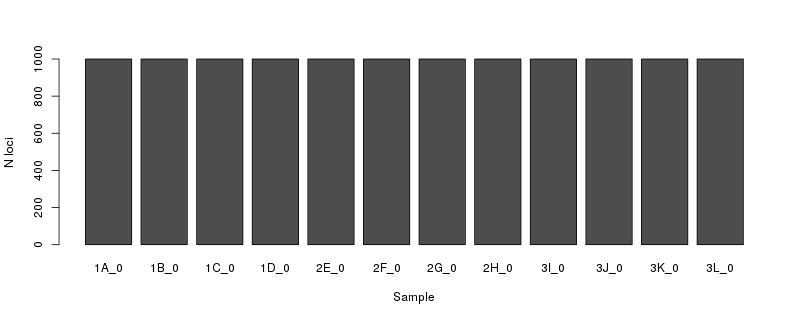

In [24]:
%%R -w 800 -h 320
## 
barplot(s7N$sample_coverage, 
        col='grey30', names=rownames(s7N),
        ylab="N loci",
        xlab="Sample")

### Plot the distribution of SNPs among loci

   var sum_var pis sum_pis
0    9       0 316       0
1   44      44 369     369
2  117     278 204     777
3  174     800  84    1029
4  182    1528  19    1105
5  165    2353   5    1130
6  143    3211   2    1142
7   76    3743   1    1149
8   45    4103   0    1149
9   25    4328   0    1149
10  14    4468   0    1149
11   5    4523   0    1149
12   0    4523   0    1149
13   1    4536   0    1149


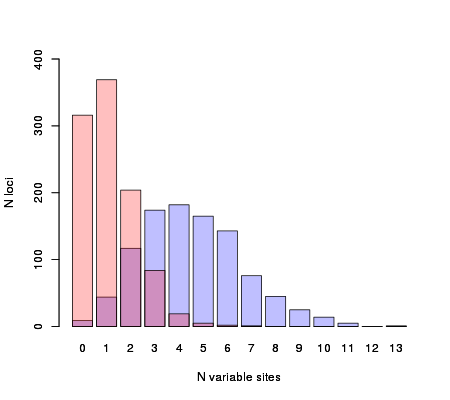

In [14]:
%%R -w 450 -h 400
print(s7S)

barplot(s7S$var, 
        col=rgb(0,0,1,1/4), 
        names=rownames(s7S),
        ylab="N loci", ylim=c(0, 400),
        xlab="N variable sites")

barplot(s7S$pis, 
        col=rgb(1,0,0,1/4), 
        names=rownames(s7S),
        ylab="N loci", ylim=c(0, 400),
        xlab="N variable sites", 
        add=TRUE)

### Future 
You can of course make much more complex figures with the data for your own Assembly. And you can also create figures to compare stats among multiple Assemblies. See also the R package RADami which has some functions for analysis and plotting using the .loci output file from ipyrad. 

If you're an R afficionado please contribute to the ipyrad cookbooks with more advanced plots or analyses, and add your notebooks to the cookbook collection by submitting them to the ipyrad github repo.  